In [1]:
import pandas as pd
from sklearn import preprocessing
import seaborn as sns
import swifter
import matplotlib.pyplot as plt 
import numpy as np
import re

In [2]:
dataPath = r'C:\Users\17656\Documents\Professional Development\Professional Projects\MBTI NLP\Scripts\\'

trainingData = pd.read_csv(dataPath + "rawTrainSet.csv")

In [3]:
trainingData.head()

,flair_text,body,cleaned
0,INFP,Lol that's why I left.,Lol that's why I left.
1,INTP,"I was just about to post ""I try telling people...","I was just about to post ""I try telling people..."
2,INFP,My first thought was Pepsi or something. Proba...,My first thought was Pepsi or something. Proba...
3,ENTP,"Not if the formula is something like ""every ti...","Not if the formula is something like ""every ti..."
4,INTP,Does this imply I'm a five now?,Does this imply I'm a five now?


Now let's strip the text of quotes and more aggressively clean the data

In [4]:
from bs4 import BeautifulSoup
from html import unescape
def ThirdPassClean(x):
    x = re.sub('\"', '', x)
    x = re.sub('http://\S+|https://\S+', '', x)
    x = BeautifulSoup(unescape(x), 'lxml').text
    x = re.sub('\[\]', ' ', x)
    x = re.sub('>', '', x)
    return x

In [5]:
trainingData["cleaned"] = trainingData.cleaned.swifter.apply(ThirdPassClean)

Pandas Apply:   0%|          | 0/25790335 [00:00<?, ?it/s]

C:\Users\17656\AppData\Local\Temp\ipykernel_2780\4161985262.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  x = BeautifulSoup(unescape(x), 'lxml').text


In [6]:
for s in trainingData["cleaned"].sample(n=5000, random_state = 123):
    print(s)
    print("================")

 Do other INTJs feel a constant need to be successful from the job/money standpoint? Yeah, dude. I'm in software, and a lot of the people on the Internet/in tech are all NTs. Making a strong, white-collar salary and being competent/autonomous are all huge themes. I think you should follow your instincts and look for something more to do.
Tate is the one I always notice as standing out from the rest of the animation, and I really dislike the style. It feels out of place and weird.
And making the assumption that a roommate, spouse or relative isn't there? If they wanted to rob a house they'd wait until the middle of the day and walk into a random empty house. Criminals who do smash and grabs like this one don't have these long drawn out plans to then hit the houses of all their victims. He needed quick, easy, and untraceable money to do whatever he needed to do. The ONLY reason he took the wallet was the hope that it had cash in it...that wallet is in a dumpster, trash can or storm drain

We're going to get rid of all punctuation and move everything to lower. While distilbert is uncased, it could still yield better results. Also going to get rid of text that's too short to meaningfully discern information from.

In [23]:
def fourthPassClean(x):
    x = x.strip()
    x = x.lower()
    x = re.sub(r'[^\w\s]', '', x)
    x = re.sub(r'\s{2,}', ' ', x) # Remove extra spaces
    
    if len(x.split()) <= 10:
        return ''
    return x

In [24]:
trainingData["cleaned"] = trainingData.cleaned.swifter.apply(fourthPassClean)

Pandas Apply:   0%|          | 0/25790335 [00:00<?, ?it/s]

In [25]:
trainingData = trainingData[~trainingData["cleaned"].eq('')].dropna()
print("Size: %d" %trainingData.shape[0])

Size: 18356173


In [27]:
trainingData["flair_text"].value_counts()

flair_text
INFP    3596843
INTP    3416452
INFJ    3262620
ENTP    2546256
INTJ    2265293
ENTJ     780831
ISTP     739495
ENFP     570701
ENFJ     358595
ISFJ     179923
ISTJ     169325
ESTP     158126
ISFP     130138
ESTJ      78059
ESFJ      53344
ESFP      50172
Name: count, dtype: int64

Let's inspect some of the text to see if it's been properly cleaned.

In [29]:
for s in trainingData["cleaned"].sample(n=5000, random_state=123):
    print(s)
    print("==============")

it said 7 pm before unless i read it somewhere else but now it says 4 pm est edit this is where it said 7 pm that page isnt accessible anymore though this is a cached version
there was also gloria steinems article about working at the playboy club in nyc very shady shit going on
the 7years war is often considered the first world war by historians it was the fighting in the americas that started first and then things spread to europe later therefore george washington started a world war
having children as a young married woman my biological clock ticks hard whenever i see or hear children my husband who is very smart and wise for this always talks me out of it as were far too young and just not financially ready still i always fantasize about teaching our children and being the most nurturing supportive mother possible it makes me giddy typing this up
well airdrop is a combo of bluetooth and wifi direct bluetooth file transfer is pretty pokey from my last experience and nfc android beam

Now let's encode the flair text to an integer label.

In [33]:
mbtiValues = ["ESTJ", "ESTP", "ESFP", "ESFJ", "ISTJ", "ISTP", "ISFP", "ISFJ", "INTJ", "INTP", "INFP",
              "INFJ", "ENTJ", "ENTP", "ENFP", "ENFJ"]

def convertToLabel(x):
    return mbtiValues.index(x)

In [35]:
trainingData["labels"] = trainingData.flair_text.swifter.apply(convertToLabel)

Pandas Apply:   0%|          | 0/18356173 [00:00<?, ?it/s]

Need to downsample data. I want to see what the distribution looks like first. 

In [36]:
trainingData["length"] = trainingData.cleaned.swifter.apply(lambda x: len(x.split()))

Pandas Apply:   0%|          | 0/18356173 [00:00<?, ?it/s]

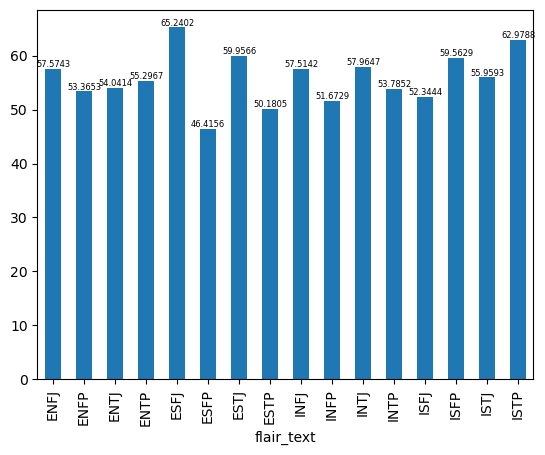

In [38]:
avgLen = trainingData.groupby('flair_text')["length"].mean()
ax = avgLen.plot.bar()
ax.bar_label(ax.containers[0], fontsize=6)
plt.show() 

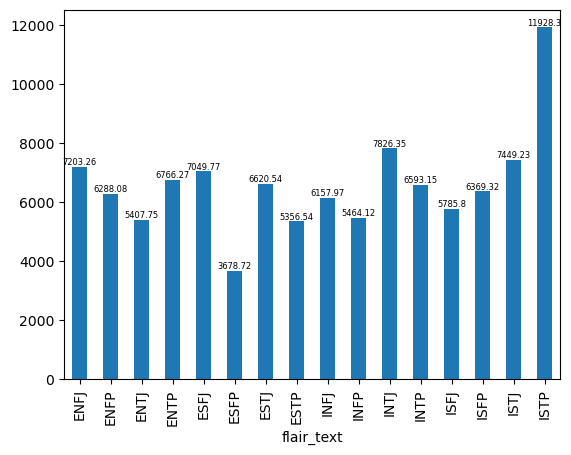

In [40]:
varLen = trainingData.groupby('flair_text')["length"].var()
ax = varLen.plot.bar()
ax.bar_label(ax.containers[0], fontsize=6)
plt.show() 

Looks like ISTP has very high variance and ESFP has very low variance in comparison the averages here. However, this should be sufficient for random sampling. We'll downsample to a random fraction of 50,172. 

In [41]:
finalDf = trainingData.groupby(['flair_text']).sample(n=50172, random_state=420)

In [42]:
finalDf["flair_text"].value_counts()

flair_text
ENFJ    50172
ENFP    50172
ENTJ    50172
ENTP    50172
ESFJ    50172
ESFP    50172
ESTJ    50172
ESTP    50172
INFJ    50172
INFP    50172
INTJ    50172
INTP    50172
ISFJ    50172
ISFP    50172
ISTJ    50172
ISTP    50172
Name: count, dtype: int64

In [44]:
trainingData.to_csv('secondCleanData.csv', index = False)
finalDf.to_csv('downsampledSecondClean.csv', index = False)